# SJSU CMPE 180A Data Structures and Algorithms in Python

**Term Project** (20 points)

** Project Name:  your_dataset_name Analytics**

Team Name:  Jet Setters (example)

Group Number: 8

Group members with SJSU IDs:


1.   Bradley Yong, 008383440
2.   Jonathan Spikes, SJSU_ID 2
3.   Lisa Leib, 018264155


Date:  August 29, 2024

Selected data set:  [US Airline Flight Routes and Fares](https://www.kaggle.com/code/nitikagupta29/us-airline-flight-routes-and-fares)

## Dataset analysis and visualisation

The goal of dataset analysis is to explain what dataset represents and to illustrate the most interesting and relevant features i.e. columns present in dataset.

Possible steps:
1. Load dataset
2. Inspect data and preprocess columns if needed
3. Visualize data (histogram, scatterplot,...)
4. Analyze dataset by plotting or presenting overview of different classes/groups/features
5. Present your results: prepare slides and an  5 to 10-minute presentation in Week 11 of the course


In [14]:
import pandas as pd

# Load the CSV file
df = pd.read_csv('airports.csv')

# Filter for American commercial airports with IATA codes and remove entries with missing data
american_commercial_airports = df[
    (df['iata_code'].notna()) & (df['iso_country'] == 'US')
]


# Save the filtered data to a new CSV file
american_commercial_airports.to_csv('american_commercial_airports.csv', index=False)

print("Filtered data saved to 'american_commercial_airports.csv'")

Filtered data saved to 'american_commercial_airports.csv'


In [26]:
import io
import csv
import requests
import geopandas as gp
import zipfile
from pathlib import Path
from IPython.display import clear_output
from typing import List, Optional, Dict, Tuple
from IPython.core.display import display

def return_total(headers: Dict[str, str]):
    """Return total length from requests header"""
    if not headers:
        return 
    total_length = headers.get('content-length')
    if not total_length:
        return
    try:
        total_length = int(total_length)
    except:
        total_length = None
    return total_length

def stream_progress(total_length: int, loaded: int):
    """Stream progress report"""
    clear_output(wait=True)            
    perc_str = ""
    if total_length:
        total = total_length/1000000
        perc = loaded/(total/100)
        perc_str = f"of {total:.2f} ({perc:.0f}%)"
    print(
        f"Loaded {loaded:.2f} MB "
        f"{perc_str}..")

def stream_progress_basic(total: int, loaded: int):
    """Stream progress report"""
    clear_output(wait=True)            
    perc_str = ""
    if total:
        perc = loaded/(total/100)
        perc_str = f"of {total:.0f} ({perc:.0f}%)"
    print(
        f"Processed {loaded:.0f} "
        f"{perc_str}..")

def get_stream_file(url: str, path: Path):
    """Download file from url and save to path"""
    chunk_size = 8192
    with requests.get(url, stream=True) as r:
        r.raise_for_status()
        total_length = return_total(r.headers)
        with open(path, 'wb') as f:
            for ix, chunk in enumerate(r.iter_content(chunk_size=chunk_size)): 
                f.write(chunk)
                loaded = (ix*chunk_size)/1000000
                if (ix % 100 == 0):
                    stream_progress(
                        total_length, loaded)
            stream_progress(
                total_length, loaded)
                        
def get_stream_bytes(url: str):
    """Stream file from url to bytes object (in-memory)"""
    chunk_size = 8192
    content = bytes()
    with requests.get(url, stream=True) as r:
        r.raise_for_status()
        total_length = return_total(r.headers)
        for ix, chunk in enumerate(r.iter_content(
                chunk_size=chunk_size)): 
            content += bytes(chunk)
            loaded = (ix*chunk_size)/1000000
            if (ix % 100 == 0):
                stream_progress(
                    total_length, loaded)
    stream_progress(
        total_length, loaded)
    return content
    
def get_folder_size(folder: Path):
    """Return size of all files in folder in MegaBytes"""
    if not folder.exists():
        raise Warning(
            f"Folder {folder} does not exist")
        return
    size_mb = 0
    for file in folder.glob('*'):
        size_mb += file.stat().st_size / (1024*1024)
    return size_mb
    
def get_zip_extract(
    uri: str, filename: str, output_path: Path, 
    create_path: bool = True, skip_exists: bool = True,
    report: bool = True, filter_files: List[str] = None,
    write_intermediate: bool = None):
    """Get Zip file and extract to output_path.
    Create Path if not exists."""
    if write_intermediate is None:
        write_intermediate = False
    if create_path:
        output_path.mkdir(
            exist_ok=True)
    if skip_exists and Path(
        output_path / filename.replace(".zip", ".csv")).exists():
        if report:
            print("File already exists.. skipping download..")
        return
    if write_intermediate:
        out_file = output_path / filename
        get_stream_file(f'{uri}{filename}', out_file)
        z = zipfile.ZipFile(out_file)
    else:
        content = get_stream_bytes(
            f'{uri}{filename}')
        z = zipfile.ZipFile(io.BytesIO(content))
    print("Extracting zip..")
    if filter_files:
        file_names = z.namelist()
        for filename in file_names:
            if filename in filter_files:
                z.extract(filename, output_path)
    else:
        z.extractall(output_path)
    if write_intermediate:
        if out_file.is_file():
            out_file.unlink()
    if report:
        raw_size_mb = get_folder_size(output_path)
        print(
            f"Retrieved {filename}, "
            f"extracted size: {raw_size_mb:.2f} MB")

def drop_cols_except(df: pd.DataFrame, columns_keep: List[str]):
    """Drop all columns from DataFrame except those specified in cols_except"""
    df.drop(
        df.columns.difference(columns_keep), axis=1, inplace=True)

def get_shapes(
        reference: str, shape_dir: Path,
        clean_cols: Optional[bool] = None, normalize_cols: Optional[bool] = None,
        set_index: Optional[bool] = None) -> gp.GeoDataFrame:
    """Custom method to get frequently used shapes (DE Bundesländer, US States)
    and return a geopandas.GeoDataFrame (WGS1984). Will only download shapes if 
    not already downloaded.

    reference: str - , "world", "us" and "de" are currently supported
    clean_cols: will remove all columns except geometry and state-reference. Defaults to True.
    normalize_cols: will rename columns to sane defaults. Defaults to True.
    set_index: will set state-reference as index column. Defaults to True.
    """
    if clean_cols is None:
        clean_cols = True
    if normalize_cols is None:
        normalize_cols = True
    if set_index is None:
        set_index = True
    target_name = "state"
    if reference == "us":
        source_zip = "https://www2.census.gov/geo/tiger/GENZ2018/shp/"
        filename = "cb_2018_us_state_5m.zip"
        shapes_name = "cb_2018_us_state_5m.shp"
        col_name = "NAME"
    elif reference == "de":
        source_zip = "https://daten.gdz.bkg.bund.de/produkte/vg/vg2500/aktuell/"
        filename = "vg2500_12-31.utm32s.shape.zip"
        shapes_name = "vg2500_12-31.utm32s.shape/vg2500/VG2500_LAN.shp"
        col_name = "GEN"
    elif reference == "world":
        source_zip = "https://naciscdn.org/naturalearth/110m/cultural/"
        filename = "ne_110m_admin_0_countries.zip"
        shapes_name = "ne_110m_admin_0_countries.shp"
        col_name = "SOVEREIGNT"
        target_name = "country"
    # create  temporary storage folder, if not exists already
    shape_dir.mkdir(exist_ok=True)
    # test if file already downloaded
    if not (shape_dir / shapes_name).exists():
        get_zip_extract(
            uri=source_zip, filename=filename, output_path=shape_dir)
    else:
        print("Already exists")
    shapes = gp.read_file(shape_dir / shapes_name)
    if clean_cols:
        drop_cols_except(df=shapes, columns_keep=["geometry", col_name])
    if normalize_cols:
        shapes.rename(columns={col_name: target_name}, inplace=True)
        col_name = target_name
    if set_index:
        shapes.set_index(col_name, inplace=True)
    return shapes.to_crs("EPSG:4326")

C:\Users\yakuz\AppData\Local\Temp\ipykernel_21100\2819062178.py:9: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display


Already exists


<Axes: >

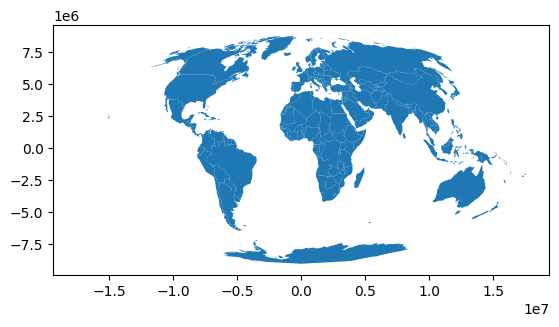

In [29]:
CRS_PROJ = "esri:54009" # Mollweide (e.g.)
world = get_shapes(
    "world", shape_dir=Path.cwd() / "shapes")
world.to_crs(CRS_PROJ, inplace=True)
world.plot()

In [65]:
import pandas as pd

flights_df = pd.read_csv('US_Airline_Flight_Routes_and_Fares_1993-2024.csv', low_memory=False)


In [47]:
flight_counts = flights_df.groupby(['airport_1', 'airport_2']).size().reset_index(name='counts')


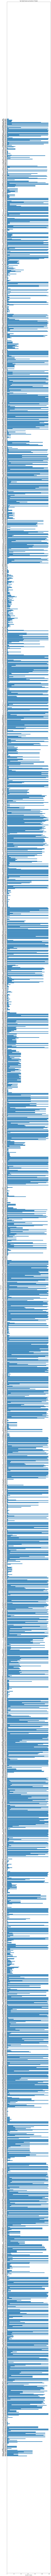

In [66]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 600))
plt.barh(flight_counts.apply(lambda x: f"{x['airport_1']} - {x['airport_2']}", axis=1), flight_counts['counts'])
plt.xlabel('Number of Flights')
plt.ylabel('Flight Route')
plt.title('Top Flight Routes by Number of Flights')
plt.gca().invert_yaxis()
plt.show()


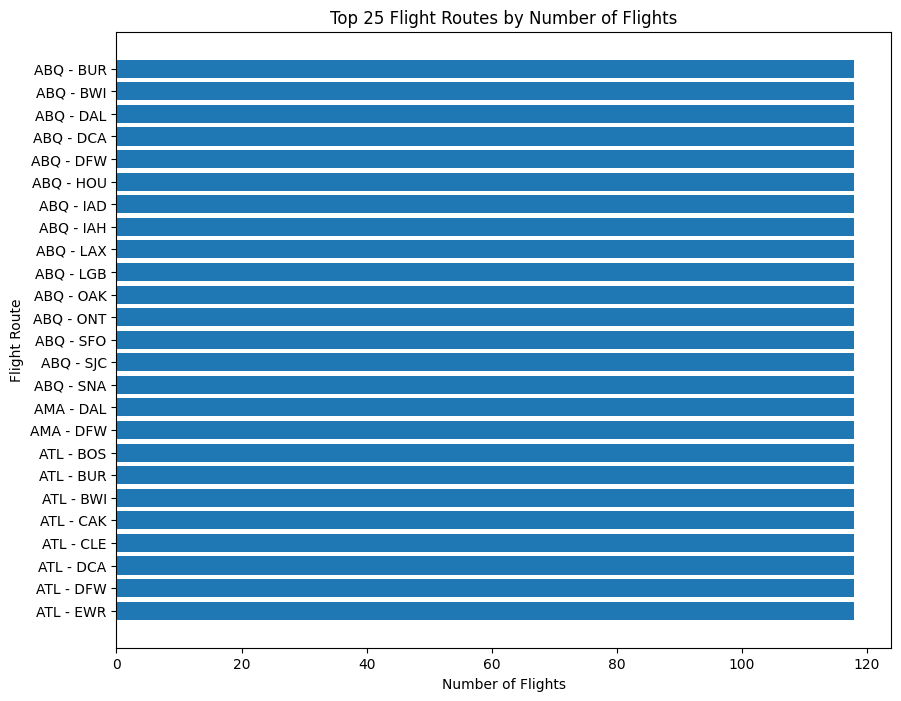

In [68]:
import matplotlib.pyplot as plt
top_25_flights = flight_counts.nlargest(25, 'counts')
plt.figure(figsize=(10, 8))
plt.barh(top_25_flights.apply(lambda x: f"{x['airport_1']} - {x['airport_2']}", axis=1), top_25_flights['counts'])
plt.xlabel('Number of Flights')
plt.ylabel('Flight Route')
plt.title('Top 25 Flight Routes by Number of Flights')
plt.gca().invert_yaxis()
plt.show()


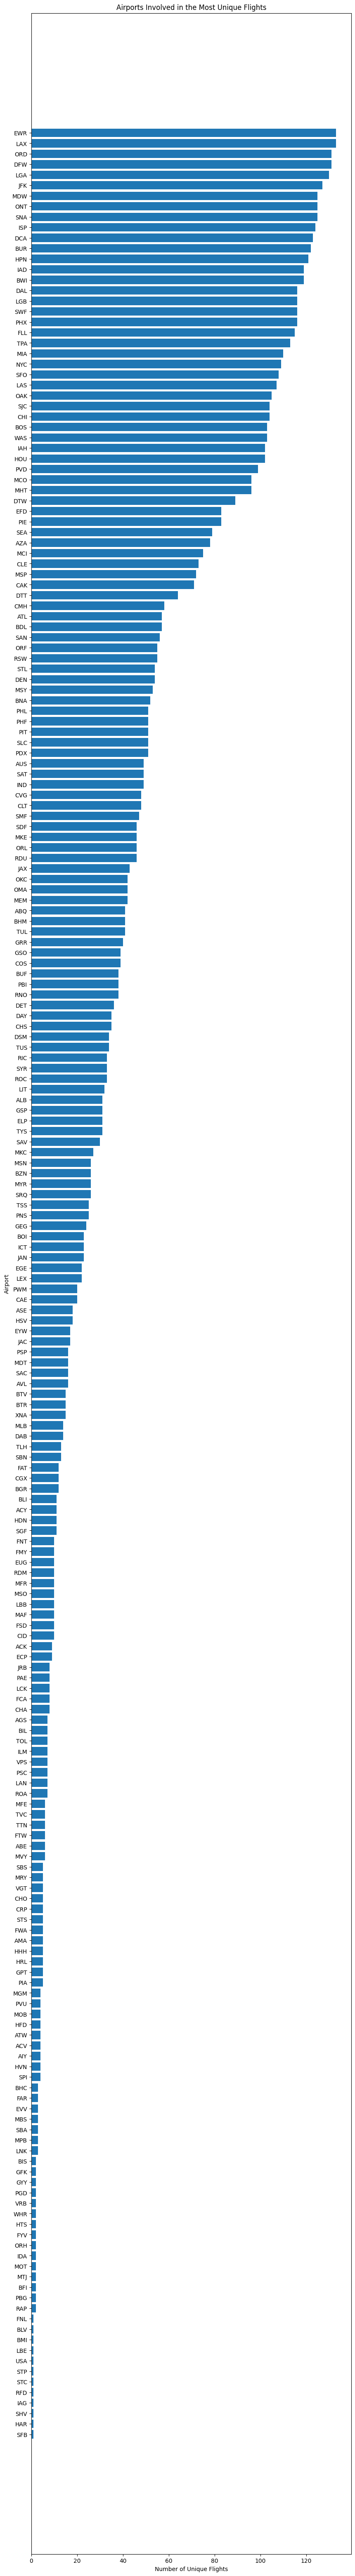

In [70]:
# Count the number of unique flights per airport
airport_counts = pd.concat([flight_counts['airport_1'], flight_counts['airport_2']]).value_counts().reset_index(name='count')
airport_counts.columns = ['airport', 'count']

# Generate a histogram for the airports involved in the most unique flights
plt.figure(figsize=(10, 80))
plt.barh(airport_counts['airport'], airport_counts['count'])
plt.xlabel('Number of Unique Flights')
plt.ylabel('Airport')
plt.title('Airports Involved in the Most Unique Flights')
plt.gca().invert_yaxis()
plt.show()

In [18]:
import geopandas as gpd

# Load the dataset from the local file
sdoh_data = gpd.read_file("ne_110m_admin_0_countries.shp")
# Filter for the USA
usa = sdoh_data[sdoh_data['country'] == 'USA']

# Create flight lines (assuming you have a DataFrame 'top_25_flights' with flight data)
flight_lines = top_25_flights.apply(lambda x: LineString([(flights_df[flights_df['iata_code'] == x['airport_1']]['longitude_deg'].values[0], flights_df[flights_df['iata_code'] == x['airport_1']]['latitude_deg'].values[0]), (flights_df[flights_df['iata_code'] == x['airport_2']]['longitude_deg'].values[0], flights_df[flights_df['iata_code'] == x['airport_2']]['latitude_deg'].values[0])]), axis=1)
flight_lines_gdf = gpd.GeoDataFrame(top_25_flights, geometry=flight_lines)

# Plot flights on USA map
fig, ax = plt.subplots(figsize=(15, 10))
usa.plot(ax=ax, color='white', edgecolor='black')
flight_lines_gdf.plot(ax=ax, linewidth=flight_lines_gdf['counts'] / 10, color='blue')
plt.title('Top 25 Most Frequent Flight Routes in the USA')
plt.show()


DriverError: Failed to open dataset (flags=68): ne_110m_admin_0_countries.shp